# Определение перспективного тарифа для телеком-компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Обзор данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv') # открываем датасет по звонкам
calls.info() # смотрим общую информацию о датасете
calls.head() # смотрим на первые пять строк датасета

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 202607 entries, 0 to 202606

Data columns (total 4 columns):

 #   Column     Non-Null Count   Dtype  

---  ------     --------------   -----  

 0   id         202607 non-null  object 

 1   call_date  202607 non-null  object 

 2   duration   202607 non-null  float64

 3   user_id    202607 non-null  int64  

dtypes: float64(1), int64(1), object(2)

memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
internet = pd.read_csv('/datasets/internet.csv') # открываем датасет по использованию интернет-трафика
internet.info() # смотрим общую информацию о датасете
internet.head() # # смотрим на первые пять строк датасета

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 149396 entries, 0 to 149395

Data columns (total 5 columns):

 #   Column        Non-Null Count   Dtype  

---  ------        --------------   -----  

 0   Unnamed: 0    149396 non-null  int64  

 1   id            149396 non-null  object 

 2   mb_used       149396 non-null  float64

 3   session_date  149396 non-null  object 

 4   user_id       149396 non-null  int64  

dtypes: float64(1), int64(2), object(2)

memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [4]:
messages = pd.read_csv('/datasets/messages.csv') # открываем датасет по сообщениям
messages.info() # смотрим общую информацию о датасете
messages.head() # смотрим на первые пять строк датасета

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 123036 entries, 0 to 123035

Data columns (total 3 columns):

 #   Column        Non-Null Count   Dtype 

---  ------        --------------   ----- 

 0   id            123036 non-null  object

 1   message_date  123036 non-null  object

 2   user_id       123036 non-null  int64 

dtypes: int64(1), object(2)

memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [5]:
tariffs = pd.read_csv('/datasets/tariffs.csv') # открываем датасет по тарифам
tariffs.info() # смотрим общую информацию о датасете
tariffs.head() # смотрим общую информацию о датасете
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
# переводим мегабайты в гигабайты для удобства работы в дальнейшем
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'].astype('int')
# переводим значения из вещественного типа в целочисленный
tariffs = tariffs.rename(columns={'mb_per_month_included': 'gb_included'})
# меняем название колонки на более точное
tariffs.head() # смотрим на первые пять строк датасета

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2 entries, 0 to 1

Data columns (total 8 columns):

 #   Column                 Non-Null Count  Dtype 

---  ------                 --------------  ----- 

 0   messages_included      2 non-null      int64 

 1   mb_per_month_included  2 non-null      int64 

 2   minutes_included       2 non-null      int64 

 3   rub_monthly_fee        2 non-null      int64 

 4   rub_per_gb             2 non-null      int64 

 5   rub_per_message        2 non-null      int64 

 6   rub_per_minute         2 non-null      int64 

 7   tariff_name            2 non-null      object

dtypes: int64(7), object(1)

memory usage: 256.0+ bytes


,messages_included,gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


In [6]:
users = pd.read_csv('/datasets/users.csv') # отркываем датасет с данными пользователей
users.info() # смотрим общую информацию о датасете
display(users.head()) # смотрим на первые пять строк датасета
users['tariff'].value_counts() # считаем количество пользователей тарифов "Смарт" и "Ультра"

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 500 entries, 0 to 499

Data columns (total 8 columns):

 #   Column      Non-Null Count  Dtype 

---  ------      --------------  ----- 

 0   user_id     500 non-null    int64 

 1   age         500 non-null    int64 

 2   churn_date  38 non-null     object

 3   city        500 non-null    object

 4   first_name  500 non-null    object

 5   last_name   500 non-null    object

 6   reg_date    500 non-null    object

 7   tariff      500 non-null    object

dtypes: int64(2), object(6)

memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


smart    351
ultra    149
Name: tariff, dtype: int64

Вывод: в нашем распоряжении 5 датасетов, содержащих информацию о количестве звонков, отправленных сообщений и использованного трафика пятисот пользователей, а также информацию о самих пользователях и составе тарифов. 

Явных проблем в датасетах не обнаружено.

## Предобработка данных

### Таблица по суммарному количеству звонков, совершённых каждым пользователем помесячно.

In [7]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
# округляем минуты разговоров в большую сторону (по правилам компании) 
# и переводим значения из вещественного типа в целочисленный
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
# перезаписываем столбец из типа "объект" в тип "дата"
calls['month'] = calls['call_date'].dt.month
# создаём отдельный столбец с месяцем
user_calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'])
# создаём сводную таблицу, в которой отражено количество минут разговора каждого пользователя,
# в каждый месяц пользования тарифом
#calls = calls.rename(columns={'(  'sum', 'duration')': 'calls_min', '(count duration)': 'calls_count'})

user_calls.info()
user_calls.columns = [ '_'.join(x) for x in user_calls.columns ]
display(user_calls.head()) # выводим первые пять строк получившейся сводной таблицы

<class 'pandas.core.frame.DataFrame'>

MultiIndex: 3174 entries, (1000, 5) to (1499, 12)

Data columns (total 2 columns):

 #   Column             Non-Null Count  Dtype

---  ------             --------------  -----

 0   (sum, duration)    3174 non-null   int64

 1   (count, duration)  3174 non-null   int64

dtypes: int64(2)

memory usage: 62.9 KB


sum_duration  count_duration
user_id month                              
1000    5               159              22
        6               172              43
        7               340              47
        8               408              52
        9               466              58

### Таблица по суммарному количеству интернет-трафика, израсходованному каждым пользователем помесячно.

In [8]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
# перезаписываем столбец из типа "объект" в тип "дата"
internet['month'] = internet['session_date'].dt.month
# создаём отдельный столбец с месяцем
user_internet = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
# создаём сводную таблицу, в которой отражено количество гигабайт, израсходованных каждым пользователем,
# в каждый месяц пользования тарифом
user_internet['mb_used'] = user_internet['mb_used'] / 1024
# переводим мегабайты в гигабайты
user_internet['mb_used'] = np.ceil(user_internet['mb_used']).astype('int')
# округляем гигабайты в большую сторону (по правилам компании) 
# и переводим значения из вещественного типа в целочисленный
user_internet.head() # выводим первые пять строк получившейся сводной таблицы

mb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15

### Таблица по суммарному количеству сообщений, отправленных каждым пользователем помесячно.

In [9]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
# перезаписываем столбец из типа "объект" в тип "дата"
messages['month'] = messages['message_date'].dt.month
# создаём отдельный столбец с месяцем
user_messages = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')
# создаём сводную таблицу, в которой отражено количество сообщений, отправленных каждым пользователем,
# в каждый месяц пользования тарифом
user_messages = user_messages.rename(columns={'message_date': 'messages'})
# меняем название колонки на более точное
user_messages.head() # выводим первые пять строк получившейся сводной таблицы

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57

### Агрегированная таблица с данными

In [10]:
data = user_calls.merge(user_internet, on=['user_id', 'month'], how='outer')
# создаём общую таблицу из сводных, присоединяя одну таблицу к другой
data = data.merge(user_messages, on=['user_id', 'month'], how='outer')
# создаём общую таблицу из сводных, присоединяя одну таблицу к другой
#data = data.merge(users[['user_id', 'tariff', 'city']], on='user_id', how='right')
# добавляем к полученной таблице данные о пользователях - каким тарифом пользуются и в каком городе живут
data = data.reset_index()
# сбрасываем индексы
data = data.merge(users[['user_id', 'tariff', 'city']], on='user_id', how='left')
# добавляем к полученной таблице данные о пользователях - каким тарифом пользуются и в каком городе живут
data['messages'] = data['messages'].fillna(0)
# пропуски заменяем на 0
data['sum_duration'] = data['sum_duration'].fillna(0)
# пропуски заменяем на 0
data['count_duration'] = data['count_duration'].fillna(0)
# пропуски заменяем на 0
data = data.rename(columns={'mb_used': 'gb_used'})
# меняем названия колонок на более корректные
data['gb_used'] = data['gb_used'].fillna(0)
# пропуски заменяем на 0
data['sum_duration'] = data['sum_duration'].astype('int')
# меняем вещественный тип на целочисленный
data['count_duration'] = data['count_duration'].astype('int')
# меняем вещественный тип на целочисленный
data['gb_used'] = data['gb_used'].astype('int')
# меняем вещественный тип на целочисленный
#data['month'] = data['month'].astype('int')
# меняем вещественный тип на целочисленный
data['messages'] = data['messages'].astype('int')
# меняем вещественный тип на целочисленный
data.info() # смотрим общую информацию о получившемся датасете
data.head() # выводим первые пять строк получившегося датасета

<class 'pandas.core.frame.DataFrame'>

Int64Index: 3214 entries, 0 to 3213

Data columns (total 8 columns):

 #   Column          Non-Null Count  Dtype 

---  ------          --------------  ----- 

 0   user_id         3214 non-null   int64 

 1   month           3214 non-null   int64 

 2   sum_duration    3214 non-null   int64 

 3   count_duration  3214 non-null   int64 

 4   gb_used         3214 non-null   int64 

 5   messages        3214 non-null   int64 

 6   tariff          3214 non-null   object

 7   city            3214 non-null   object

dtypes: int64(6), object(2)

memory usage: 226.0+ KB


,user_id,month,sum_duration,count_duration,gb_used,messages,tariff,city
0,1000,5,159,22,3,22,ultra,Краснодар
1,1000,6,172,43,23,60,ultra,Краснодар
2,1000,7,340,47,14,75,ultra,Краснодар
3,1000,8,408,52,14,81,ultra,Краснодар
4,1000,9,466,58,15,57,ultra,Краснодар


### Столбец с выручкой от каждого пользователя помесячно

In [11]:
def income_sum(row):
    sum_duration = row['sum_duration']
    gb_used = row['gb_used']
    messages = row['messages']
    tariff = row['tariff']
    
    if tariff == 'smart':
        income = tariffs.loc[0, 'rub_monthly_fee']
        if sum_duration > tariffs.loc[0, 'minutes_included']:
            income += ((sum_duration - tariffs.loc[0, 'minutes_included']) * tariffs.loc[0, 'rub_per_minute'])
        if messages > tariffs.loc[0, 'messages_included']:
            income += ((messages - tariffs.loc[0, 'messages_included']) * tariffs.loc[0, 'rub_per_message'])
        if gb_used > tariffs.loc[0, 'gb_included']:
            income += ((gb_used - tariffs.loc[0, 'gb_included']) * tariffs.loc[0, 'rub_per_gb'])
        return income
    
    if tariff == 'ultra':
        income = tariffs.loc[1, 'rub_monthly_fee']
        if sum_duration > tariffs.loc[1, 'minutes_included']:
            income += ((sum_duration - tariffs.loc[1, 'minutes_included']) * tariffs.loc[1, 'rub_per_minute'])
        if messages > tariffs.loc[1, 'messages_included']:
            income += ((messages - tariffs.loc[1, 'messages_included']) * tariffs.loc[1, 'rub_per_message'])
        if gb_used > tariffs.loc[1, 'gb_included']:
            income += ((gb_used - tariffs.loc[1, 'gb_included']) * tariffs.loc[1, 'rub_per_gb'])
        return income
    
# Написали функцию, которая посчитает выручку от каждого пользователя в зависимости от тарифа, которым
# он пользуется, и запишет это значения в отдельный столбец

In [12]:
data['income'] = data.apply(income_sum, axis=1)
# применяем написанную функцию для создания нового столбца с информацией о выручке от каждого пользователя
data.head() # выводим первые пять строк получившегося датасета

,user_id,month,sum_duration,count_duration,gb_used,messages,tariff,city,income
0,1000,5,159,22,3,22,ultra,Краснодар,1950
1,1000,6,172,43,23,60,ultra,Краснодар,1950
2,1000,7,340,47,14,75,ultra,Краснодар,1950
3,1000,8,408,52,14,81,ultra,Краснодар,1950
4,1000,9,466,58,15,57,ultra,Краснодар,1950


Вывод: в результаты предобработки данных собрали в одну таблицу всю информацию, которая будет нам нужна для дальнейшего анализа данных.

## Анализ данных

### Пользователи тарифа Smart

In [13]:
data_smart = data.query('tariff == "smart"')
# создаём датасет с пользователями тарифа "Смарт"
data_smart.info() # смотрим общую информацию о получившемся датасете
display(data_smart.describe()) # смотрим информацию о данных датасета
data_smart.head() # выводим первые пять строк получившегося датасета

<class 'pandas.core.frame.DataFrame'>

Int64Index: 2229 entries, 8 to 3213

Data columns (total 9 columns):

 #   Column          Non-Null Count  Dtype 

---  ------          --------------  ----- 

 0   user_id         2229 non-null   int64 

 1   month           2229 non-null   int64 

 2   sum_duration    2229 non-null   int64 

 3   count_duration  2229 non-null   int64 

 4   gb_used         2229 non-null   int64 

 5   messages        2229 non-null   int64 

 6   tariff          2229 non-null   object

 7   city            2229 non-null   object

 8   income          2229 non-null   int64 

dtypes: int64(7), object(2)

memory usage: 174.1+ KB


,user_id,month,sum_duration,count_duration,gb_used,messages,income
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,8.346792,417.934948,58.463437,16.328847,33.384029,1289.973531
std,146.119496,2.920316,190.313730,25.939858,5.747061,28.227876,818.404367
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,6.000000,282.000000,40.000000,13.000000,10.000000,550.000000
50%,1239.000000,9.000000,422.000000,60.000000,17.000000,28.000000,1023.000000
75%,1376.000000,11.000000,545.000000,76.000000,20.000000,51.000000,1750.000000
max,1499.000000,12.000000,1435.000000,198.000000,38.000000,143.000000,6770.000000


,user_id,month,sum_duration,count_duration,gb_used,messages,tariff,city,income
8,1001,11,430,59,18,0,smart,Москва,1150
9,1001,12,414,63,14,0,smart,Москва,550
10,1002,6,117,15,11,4,smart,Стерлитамак,550
11,1002,7,214,26,18,11,smart,Стерлитамак,1150
12,1002,8,289,42,20,13,smart,Стерлитамак,1550


#### Анализируем звонки

Среднее значение: 417.9349484073576

Дисперсия: 36219.31578434428

Стандартное отклонение: 190.27103471651876


Text(0, 0.5, 'Кол-во пользователей')

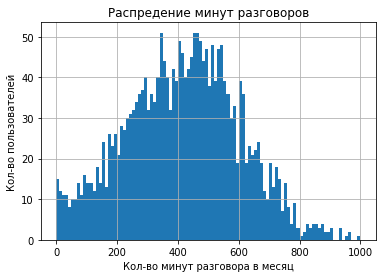

In [14]:
mean_calls_s = data_smart['sum_duration'].mean()
print('Среднее значение:', mean_calls_s)
# считаем и выводим среднее значение
var_calls_s = np.var(data_smart['sum_duration'], ddof=1)
print('Дисперсия:', var_calls_s)
# считаем и выводим дисперсию
std_calls_s = np.std(data_smart['sum_duration'])
print('Стандартное отклонение:', std_calls_s)
# считаем и выводим стандартное отклонение
data_smart['sum_duration'].hist(bins=100, range=(0, 1000))
# строим гистограмму распределения частот
plt.title('Распредение минут разговоров')
plt.xlabel('Кол-во минут разговора в месяц')
plt.ylabel('Кол-во пользователей')

Вывод: распределение продолжительности звонков у пользователей тарифа "Смарт" близко к нормальному, есть небольшая скошенность влево. Среднее количество минут разговора в месяц составялет 418, что достаточно близко к медиане (422), что также говорит о том, что значения распределены достаточно равномерно, нет явных выбросовов.
При этом, стандартное отколонение также достаточно велико, это говорит о том, что пользователи тарифа "Смарт" неоднородны в своих сценариях - кто-то говорит мало или не говорит совсем, другие наоборот разговаривают очень много. 75% пользователей укладываются в 545 минут, что немного больше включенного в тариф количества звонков в 500 минут.

#### Анализируем сообщения

Среднее значение: 33.384028712427096

Дисперсия: 796.8129584480083

Стандартное отклонение: 28.221542886898938


Text(0, 0.5, 'Кол-во пользователей')

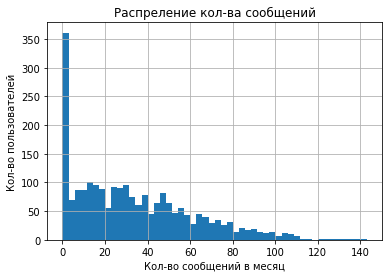

In [15]:
mean_mess_s = data_smart['messages'].mean()
print('Среднее значение:', mean_mess_s)
# считаем и выводим среднее значение
var_mess_s = np.var(data_smart['messages'], ddof=1)
print('Дисперсия:', var_mess_s)
# считаем и выводим дисперсию
std_mess_s = np.std(data_smart['messages'])
print('Стандартное отклонение:', std_mess_s)
# считаем и выводим стандартное отклонение
data_smart['messages'].hist(bins=50)
# строим гистограмму распределения частот
plt.title('Распреление кол-ва сообщений')
plt.xlabel('Кол-во сообщений в месяц')
plt.ylabel('Кол-во пользователей')

Вывод: значения на гистограмме сильно скошены влево. Среднее значение (33) близко к медиане (28), но при этом мы видим высокое стандарное отклонение, что говорит нам о том, что значения сильно разбросаны. Значительный вклад в это вности то, что большое количество пользоватлей отправляет не отправляет сообщения вообще. При этом, 75% пользователей укладывается в 51 сообщений, что близко к количеству, входящему в тариф (50).

#### Анализируем интернет-трафик

Среднее значение: 16.328847016599372

Дисперсия: 33.02870517811161

Стандартное отклонение: 5.745771267187499


Text(0, 0.5, 'Кол-во пользователей')

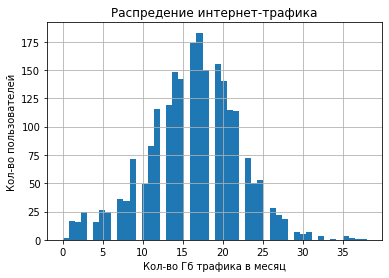

In [16]:
mean_int_s = data_smart['gb_used'].mean()
print('Среднее значение:', mean_int_s)
# считаем и выводим среднее значение
var_int_s = np.var(data_smart['gb_used'], ddof=1)
print('Дисперсия:', var_int_s)
# считаем и выводим дисперсию
std_int_s = np.std(data_smart['gb_used'])
print('Стандартное отклонение:', std_int_s)
# считаем и выводим стандартное отклонение
data_smart['gb_used'].hist(bins=50)
# строим гистограмму распределения частот
plt.title('Распредение интернет-трафика')
plt.xlabel('Кол-во Гб трафика в месяц')
plt.ylabel('Кол-во пользователей')

Вывод: можно сказать, что использование трафика среди пользователей тарифа "Смарт" распределено нормально. Среднее значение (16) и медиана (17) практически равны. Стандартное отклонение достаточно большое, но не запредельное. Количество интернет-трафика, используемого в среднем, немного выше того значения, что входит в тариф (15).

#### Общий вывод

Пользователи тарифа "Смарт", в среднем, разговаривают 418 минут, отправляют 33 сообщений и расходуют 16 Гб интернет-трафика в месяц. Интернет-трафика используют немного больше, чем включено в тариф, звонки и сообщения укладываются в лимит.

### Пользователи тарифа Ultra

In [17]:
data_ultra = data.query('tariff == "ultra"')
data_ultra.info() # смотрим общую информацию о получившемся датасете
display(data_ultra.describe()) # смотрим информацию о данных датасета
data_ultra.head() # выводим первые пять строк получившегося датасета

<class 'pandas.core.frame.DataFrame'>

Int64Index: 985 entries, 0 to 3208

Data columns (total 9 columns):

 #   Column          Non-Null Count  Dtype 

---  ------          --------------  ----- 

 0   user_id         985 non-null    int64 

 1   month           985 non-null    int64 

 2   sum_duration    985 non-null    int64 

 3   count_duration  985 non-null    int64 

 4   gb_used         985 non-null    int64 

 5   messages        985 non-null    int64 

 6   tariff          985 non-null    object

 7   city            985 non-null    object

 8   income          985 non-null    int64 

dtypes: int64(7), object(2)

memory usage: 77.0+ KB


,user_id,month,sum_duration,count_duration,gb_used,messages,income
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1263.094416,8.250761,526.623350,73.392893,19.494416,49.363452,2070.152284
std,140.694908,2.871762,317.606098,43.916853,9.853511,47.804457,376.187114
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1950.000000
25%,1143.000000,6.000000,284.000000,41.000000,12.000000,6.000000,1950.000000
50%,1277.000000,9.000000,518.000000,74.000000,19.000000,38.000000,1950.000000
75%,1381.000000,11.000000,752.000000,104.000000,27.000000,79.000000,1950.000000
max,1495.000000,12.000000,1673.000000,244.000000,49.000000,224.000000,4800.000000


,user_id,month,sum_duration,count_duration,gb_used,messages,tariff,city,income
0,1000,5,159,22,3,22,ultra,Краснодар,1950
1,1000,6,172,43,23,60,ultra,Краснодар,1950
2,1000,7,340,47,14,75,ultra,Краснодар,1950
3,1000,8,408,52,14,81,ultra,Краснодар,1950
4,1000,9,466,58,15,57,ultra,Краснодар,1950


#### Анализируем звонки

Среднее значение: 526.6233502538071

Дисперсия: 100873.63339730098

Стандартное отклонение: 317.44483554974113


Text(0, 0.5, 'Кол-во пользователей')

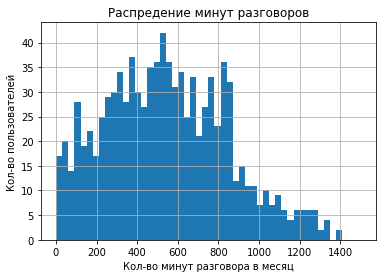

In [18]:
mean_calls_u = data_ultra['sum_duration'].mean()
print('Среднее значение:', mean_calls_u)
# считаем и выводим среднее значение
var_calls_u = np.var(data_ultra['sum_duration'], ddof=1)
print('Дисперсия:', var_calls_u)
# считаем и выводим дисперсию
std_calls_u = np.std(data_ultra['sum_duration'])
print('Стандартное отклонение:', std_calls_u)
# считаем и выводим стандартное отклонение
data_ultra['sum_duration'].hist(bins=50, range=(1, 1500))
# строим гистограмму распределения частот
plt.title('Распредение минут разговоров')
plt.xlabel('Кол-во минут разговора в месяц')
plt.ylabel('Кол-во пользователей')

Вывод: гистограмма имеет скошенность влево. Среднее количество минут разговоров у пользователей тарифа "Ультра" составляет 526, что ненамного больше значения пользователей тарифа "Смарт" (426). 75% пользователей укладываются в 752 минуты разговора в месяц. Полный пакет минут (3000) не выговаривает никто.

#### Анализируем сообщения

Среднее значение: 49.36345177664975

Дисперсия: 2285.2661425446736

Стандартное отклонение: 47.78018496610161


Text(0, 0.5, 'Кол-во пользователей')

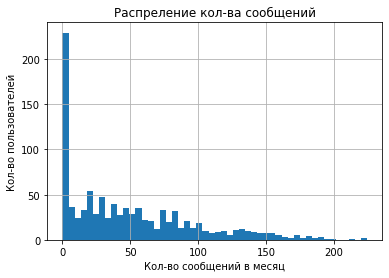

In [19]:
mean_mess_u = data_ultra['messages'].mean()
print('Среднее значение:', mean_mess_u)
# считаем и выводим среднее значение
var_mess_u = np.var(data_ultra['messages'], ddof=1)
print('Дисперсия:', var_mess_u)
# считаем и выводим дисперсию
std_mess_u = np.std(data_ultra['messages'])
print('Стандартное отклонение:', std_mess_u)
# считаем и выводим стандартное отклонение
data_ultra['messages'].hist(bins=50)
# строим гистограмму распределения частот
plt.title('Распреление кол-ва сообщений')
plt.xlabel('Кол-во сообщений в месяц')
plt.ylabel('Кол-во пользователей')

Вывод: гистограмма имеет скошенность влево, как и у пользователей тарифа "Смарт", только среднее значение отправляемых сообщений больше (49 против 31). 75% пользователей укладываются в 79 сообщений в месяц. Как и со звонками, максимум включенных в пакет сообщений (1000) не использует никто. Также как и на тарифе "Смарт", достаточно большое количество пользователей вообще не отправляет сообщения, что также влияет на высокое стандартное отклонение (47), практически равное среднему значению.

#### Анализируем интернет-трафик

Среднее значение: 19.494416243654822

Дисперсия: 97.09168626965459

Стандартное отклонение: 9.848508314957495


Text(0, 0.5, 'Кол-во пользователей')

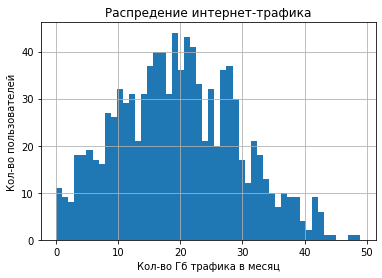

In [20]:
mean_int_u = data_ultra['gb_used'].mean()
print('Среднее значение:', mean_int_u)
# считаем и выводим среднее значение
var_int_u = np.var(data_ultra['gb_used'], ddof=1)
print('Дисперсия:', var_int_u)
# считаем и выводим дисперсию
std_int_u = np.std(data_ultra['gb_used'])
print('Стандартное отклонение:', std_int_u)
# считаем и выводим стандартное отклонение
data_ultra['gb_used'].hist(bins=50)
# строим гистограмму распределения частот
plt.title('Распредение интернет-трафика')
plt.xlabel('Кол-во Гб трафика в месяц')
plt.ylabel('Кол-во пользователей')

Вывод: распределение использование интернет-трафика у пользователей тарифа "Ультра" похоже на нормальное. Но среднее количество трафика выше (19 против 16) по сравнению с пользователями тарифа "Смарт". 75% пользователей укладываются 27 Гб трафика, что попадает в лимит тарифа (30).

#### Общий вывод

Пользователи тарифа "Ультра", в среднем, разговаривают 526 минут, отправляют 49 сообщений и расходуют 27 Гб интернет-трафика. Звонят, пишут и используют интернет-трафик пользователи тарифа "Ультра" больше, чем пользователи тарифа "Смарт", но, в среднем, укладываются в лимиты по тарифу.

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Нулевая гипотеза: средняя выручка пользователей тарифов "Ультра" и "Смарт" совпадают.

Альтернативная гипотеза: средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются.

In [21]:
alpha = .05
# задаём уровень значимости
results = st.ttest_ind(data_smart['income'], data_ultra['income'], equal_var=False)
# сравниваем выборочные средние значения тарифов "Смарт" и "Ультра"
print('p-значение:', results.pvalue)
print('Средння выручка от одного пользователя на тарифе Ultra:', data_ultra['income'].mean().round())
print('Средняя выручка от одного пользователя на тарифе Smart:', data_smart['income'].mean().round())
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250

Средння выручка от одного пользователя на тарифе Ultra: 2070.0

Средняя выручка от одного пользователя на тарифе Smart: 1290.0

Отвергаем нулевую гипотезу


Вывод: средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются, значит отвергаем нулевую гипотезу в пользу альтернативной. 

Сравнив средние значения, мы видим, что выручка пользователей на тарифе "Ультра" почти в 1.5 раза выше, чем выручка пользователей на тарифе "Смарт"

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [22]:
data_msc = data.query('city == "Москва"')
# создаём датасет с пользователями из Москвы
data_reg = data.query('city != "Москва"')
# создаём датасет с пользователями из других городов
display(data_msc.head()) # выводим первые пять строк получившегося датасета
data_msc.info() # смотрим общую информацию о датасете
display(data_msc.describe()) # смотрим информацию о данных датасета
display(data_reg.head()) # выводим первые пять строк получившегося датасета
data_reg.info() # смотрим общую информацию о датасете
data_reg.describe() # смотрим информацию о данных датасета

,user_id,month,sum_duration,count_duration,gb_used,messages,tariff,city,income
8,1001,11,430,59,18,0,smart,Москва,1150
9,1001,12,414,63,14,0,smart,Москва,550
17,1003,8,380,55,9,37,ultra,Москва,1950
18,1003,9,961,134,13,91,ultra,Москва,1950
19,1003,10,855,108,15,83,ultra,Москва,1950


<class 'pandas.core.frame.DataFrame'>

Int64Index: 611 entries, 8 to 3208

Data columns (total 9 columns):

 #   Column          Non-Null Count  Dtype 

---  ------          --------------  ----- 

 0   user_id         611 non-null    int64 

 1   month           611 non-null    int64 

 2   sum_duration    611 non-null    int64 

 3   count_duration  611 non-null    int64 

 4   gb_used         611 non-null    int64 

 5   messages        611 non-null    int64 

 6   tariff          611 non-null    object

 7   city            611 non-null    object

 8   income          611 non-null    int64 

dtypes: int64(7), object(2)

memory usage: 47.7+ KB


,user_id,month,sum_duration,count_duration,gb_used,messages,income
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000
mean,1268.872340,8.432079,469.150573,65.436989,18.050736,37.877250,1546.713584
std,137.530432,2.888057,241.535044,33.186021,7.645788,37.160304,752.088071
min,1001.000000,1.000000,0.000000,0.000000,1.000000,0.000000,550.000000
25%,1171.000000,6.000000,304.000000,42.000000,13.000000,6.500000,780.500000
50%,1291.000000,9.000000,453.000000,64.000000,18.000000,29.000000,1750.000000
75%,1385.000000,11.000000,620.500000,85.500000,22.000000,57.000000,1950.000000
max,1490.000000,12.000000,1321.000000,188.000000,44.000000,191.000000,5321.000000


,user_id,month,sum_duration,count_duration,gb_used,messages,tariff,city,income
0,1000,5,159,22,3,22,ultra,Краснодар,1950
1,1000,6,172,43,23,60,ultra,Краснодар,1950
2,1000,7,340,47,14,75,ultra,Краснодар,1950
3,1000,8,408,52,14,81,ultra,Краснодар,1950
4,1000,9,466,58,15,57,ultra,Краснодар,1950


<class 'pandas.core.frame.DataFrame'>

Int64Index: 2603 entries, 0 to 3213

Data columns (total 9 columns):

 #   Column          Non-Null Count  Dtype 

---  ------          --------------  ----- 

 0   user_id         2603 non-null   int64 

 1   month           2603 non-null   int64 

 2   sum_duration    2603 non-null   int64 

 3   count_duration  2603 non-null   int64 

 4   gb_used         2603 non-null   int64 

 5   messages        2603 non-null   int64 

 6   tariff          2603 non-null   object

 7   city            2603 non-null   object

 8   income          2603 non-null   int64 

dtypes: int64(7), object(2)

memory usage: 203.4+ KB


,user_id,month,sum_duration,count_duration,gb_used,messages,income
count,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000
mean,1247.533615,8.290434,447.041875,62.475989,17.122551,38.376104,1524.936227
std,146.011387,2.909368,241.852152,33.229464,7.332184,35.913289,808.787752
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1120.000000,6.000000,280.500000,40.000000,13.000000,9.500000,750.000000
50%,1241.000000,9.000000,440.000000,62.000000,17.000000,30.000000,1583.000000
75%,1377.000000,11.000000,584.000000,82.000000,21.000000,57.000000,1950.000000
max,1499.000000,12.000000,1673.000000,244.000000,49.000000,224.000000,6770.000000


Нулевая гипотеза: средняя выручка пользователей в Москве не отличается от средней выручки пользователей других городов.

Альтернативная гипотеза: средняя выручка пользователей в Москве отличается от средней выручки пользователей других городов.

In [23]:
alpha = .05
# задаём уровень значимости
results = st.ttest_ind(data_msc['income'], data_reg['income'], equal_var=False)
# сравниваем выборочные средние значения пользователей из Москвы и из других городов
print('p-значение:', results.pvalue)
print('Средння выручка от одного пользователя в Москве:', data_msc['income'].mean().round())
print('Средняя выручка от одного пользователя в другом городе:', data_reg['income'].mean().round())
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298

Средння выручка от одного пользователя в Москве: 1547.0

Средняя выручка от одного пользователя в другом городе: 1525.0

Не получилось отвергнуть нулевую гипотезу


Вывод: по результатам теста нельзя отвергнуть нулевую гипотезу, сравнение средних говорит нам о том же - средняя выручка пользователя из Москвы практически не отличается от средней выручки пользователя из другого региона.

## Общий вывод

Как показало исследование, пользователи тарифа "Ультра" существенно выгоднее для компании, чем пользователи тарифа "Смарт", т.к. их средняя выручка почти в 1.5 раза выше. 

Но пользователей тарифа "Смарт" более, чем в 2 раза больше, чем пользователей тарифа "Ультра" (351 против 149), что говорит о том, что продаётся данный тариф лучше.

Если перемножить среднюю выручку каждого из тарифов на количество пользователей, то видно, что больше денег компании приносят пользователи тарифа "Смарт" (452 т.р./мес. против 308 т.р./мес.) в силу их большего количества. При этом, предполагаю, что маржинальность на тарифу "Ультра" для компании существенно выше, т.к. пользователи данного тарифа расходуют звонков, сообщений и интернет-трафика ненамного больше.

В силу вышесказанного, имеет смысл увеличить рекламный бюджет на продвижение тарифа "Ультра".

При этом, выручка у пользователей из других регионов практически не отличается от пользователей из Москвы, что говорит о том, что пользователи в любых городах одинаковы важны для компании.